In [1]:
import os
import time
import glob
import pickle
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from baseline import *

In [2]:
seed = 1
device = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device=="cuda":
    torch.cuda.manual_seed(seed)

## Prepare Dataset

In [3]:
train_G, prediction_links = pickle.load(open('input_{}.pkl'.format(1), 'rb'))

node_features = pickle.load(open('node_features.pkl', 'rb'))
text_features = np.array(list(node_features.values()))
nnodes = text_features.shape[0]

pca = PCA(n_components=100)
pca.fit(text_features)
emb_features = pca.transform(text_features)
emb_features = torch.from_numpy(emb_features).to(device).float()
    
adj = {k:{k} for k in range(nnodes)}
for node in list(train_G.nodes()):
    adj[node] = adj[node].union(list(train_G[node]))
adj = [np.sort(list(v)) for k,v in adj.items()]

## Parameters

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

nlayer = 2
dims = [100]*(nlayer+1)
dropout = 0.4

lr = 0.005
weight_decay = 0.0005

nepoch = 100

## Evaluation

In [5]:
cos = nn.CosineSimilarity()

def lp_eval(embeds):
    lp_input = torch.stack([embeds[prediction_links[:,0]], embeds[prediction_links[:,1]]])
    similarity = cos(lp_input[0], lp_input[1]).detach().cpu().numpy()
    pred = expit(similarity)>0.5
    labels = prediction_links[:,-1]
    f1, accuracy = f1_score(labels, pred), accuracy_score(labels, pred)
    return accuracy, f1

In [6]:
pdist = nn.PairwiseDistance()
edges = np.array(list(train_G.edges()))

def edge_diff(embeds):
    diff = pdist(embeds[edges[:,0]], embeds[edges[:,1]])
    return torch.mean(diff).cpu().item()

## Unsupervised Training, Input = initial features, Loss = - (output embedding - input embedding)

In [7]:
def unsup1(model, optimizer, epoch, prev_embeds):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    
    embeds = model(emb_features, adj)
    loss = -torch.mean(pdist(embeds, emb_features))
    
    loss.backward()
    optimizer.step()
    
    accuracy, f1 = lp_eval(embeds)    
    curr_edge_diff = edge_diff(embeds)
    curr_embed_diff = torch.mean(pdist(embeds, prev_embeds)).cpu().item()
    curr_input_diff = -loss.item()   
    
    
    if (epoch+1)%1==0:
        print('Epoch: {} || Acc: {:.4f}, F1: {:.4f} || Edge_diff: {:.4f}, Embed_diff: {:.4f}, Input_diff: {:.4f} || Time: {:.4f}s'
              .format(epoch, accuracy, f1, curr_edge_diff, curr_embed_diff, curr_input_diff, time.time()-t))
    
    return accuracy, curr_edge_diff, curr_embed_diff, curr_input_diff, embeds

In [8]:
t_total = time.time()

model = GraphSAGEModel(dims=dims, dropout=dropout, nlayer=nlayer, device=device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

prev_embeds = emb_features
acc_values, edge_diffs, embed_diffs, input_diffs = [], [], [], []
for epoch in range(nepoch):
    acc_value, curr_edge_diff, curr_embed_diff, curr_input_diff, prev_embeds = unsup1(model, optimizer, epoch, prev_embeds.detach())
    
    acc_values.append(acc_value)
    edge_diffs.append(curr_edge_diff)
    embed_diffs.append(curr_embed_diff)
    input_diffs.append(curr_input_diff)
    
torch.save(model.state_dict(), 'Unsupervised/Version_3.pkl')  
        
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

Epoch: 0 || Acc: 0.5000, F1: 0.6667 || Edge_diff: 0.3807, Embed_diff: 1.3241, Input_diff: 1.3241 || Time: 5.8954s
Epoch: 1 || Acc: 0.5000, F1: 0.6667 || Edge_diff: 0.3810, Embed_diff: 0.6418, Input_diff: 1.3642 || Time: 5.7521s
Epoch: 2 || Acc: 0.5000, F1: 0.6667 || Edge_diff: 0.4105, Embed_diff: 0.6627, Input_diff: 1.4067 || Time: 5.8276s
Epoch: 3 || Acc: 0.5000, F1: 0.6667 || Edge_diff: 0.4246, Embed_diff: 0.7022, Input_diff: 1.4477 || Time: 5.7471s
Epoch: 4 || Acc: 0.5000, F1: 0.6667 || Edge_diff: 0.4172, Embed_diff: 0.6906, Input_diff: 1.4817 || Time: 5.7863s
Epoch: 5 || Acc: 0.5000, F1: 0.6667 || Edge_diff: 0.3947, Embed_diff: 0.6337, Input_diff: 1.5045 || Time: 5.8297s
Epoch: 6 || Acc: 0.5000, F1: 0.6667 || Edge_diff: 0.3815, Embed_diff: 0.5751, Input_diff: 1.5217 || Time: 5.7883s
Epoch: 7 || Acc: 0.5000, F1: 0.6667 || Edge_diff: 0.3721, Embed_diff: 0.5411, Input_diff: 1.5327 || Time: 5.8084s
Epoch: 8 || Acc: 0.5006, F1: 0.6669 || Edge_diff: 0.3785, Embed_diff: 0.5039, Input_diff

Epoch: 72 || Acc: 0.5000, F1: 0.6667 || Edge_diff: 0.4308, Embed_diff: 0.4987, Input_diff: 1.6037 || Time: 5.7280s
Epoch: 73 || Acc: 0.5000, F1: 0.6667 || Edge_diff: 0.4305, Embed_diff: 0.5015, Input_diff: 1.6038 || Time: 5.8149s
Epoch: 74 || Acc: 0.5000, F1: 0.6667 || Edge_diff: 0.4290, Embed_diff: 0.5006, Input_diff: 1.6050 || Time: 5.7813s
Epoch: 75 || Acc: 0.5000, F1: 0.6667 || Edge_diff: 0.4343, Embed_diff: 0.4997, Input_diff: 1.6051 || Time: 5.8264s
Epoch: 76 || Acc: 0.5000, F1: 0.6667 || Edge_diff: 0.4344, Embed_diff: 0.4968, Input_diff: 1.6057 || Time: 5.7707s
Epoch: 77 || Acc: 0.5000, F1: 0.6667 || Edge_diff: 0.4326, Embed_diff: 0.4971, Input_diff: 1.6056 || Time: 5.8118s
Epoch: 78 || Acc: 0.5000, F1: 0.6667 || Edge_diff: 0.4316, Embed_diff: 0.5002, Input_diff: 1.6055 || Time: 5.7608s
Epoch: 79 || Acc: 0.5000, F1: 0.6667 || Edge_diff: 0.4311, Embed_diff: 0.4943, Input_diff: 1.6067 || Time: 5.8020s
Epoch: 80 || Acc: 0.5000, F1: 0.6667 || Edge_diff: 0.4307, Embed_diff: 0.4955, I

Text(0.5, 1.0, 'Training Accuracy Curve')

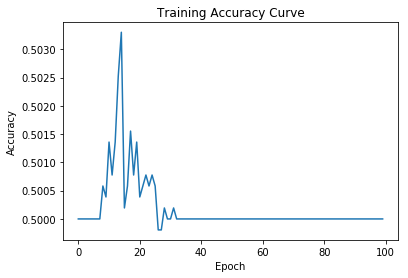

In [9]:
plt.plot(acc_values)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')

Text(0.5, 1.0, 'Training Edge-wise Distance Curve')

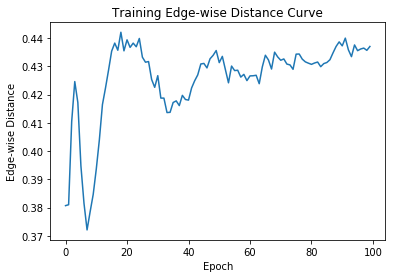

In [10]:
plt.plot(edge_diffs)
plt.xlabel('Epoch')
plt.ylabel('Edge-wise Distance')
plt.title('Training Edge-wise Distance Curve')

Text(0.5, 1.0, 'Change in Embedding Curve')

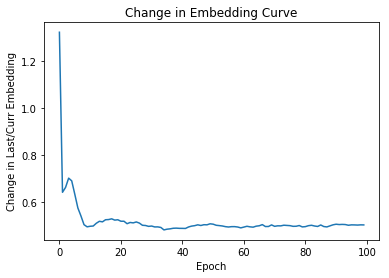

In [11]:
plt.plot(embed_diffs)
plt.xlabel('Epoch')
plt.ylabel('Change in Last/Curr Embedding')
plt.title('Change in Embedding Curve')

Text(0.5, 1.0, 'Change in Input/Output Curve')

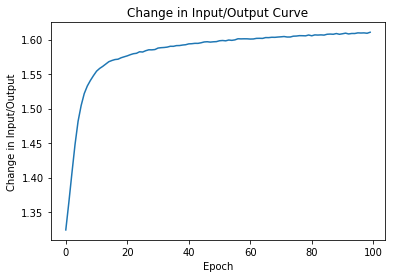

In [12]:
plt.plot(input_diffs)
plt.xlabel('Epoch')
plt.ylabel('Change in Input/Output')
plt.title('Change in Input/Output Curve')

In [13]:
pickle.dump((acc_values, edge_diffs, embed_diffs, input_diffs), open('unsupervised_experiments_3.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)